In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from scipy.special import expit
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures

import sympy as sp

# DGP

$$
r^*(p) = x\theta + w
$$

$$
r(r*) = \dfrac{1}{1+e^{r^*}}
$$

$$
amt(r^*) = a + b r^*
$$

$$
loss(r^*) = amt(r^*)r(r*)
$$

$$
rev(r^*) = amt(r^*)((x+1)^n - 1)
$$


In [2]:
x, theta, w = sp.symbols('x theta w')

r_star = x*theta + w
r = 1/(1+sp.exp(r_star))

a, b = sp.symbols('a b')

amt = a + b * r_star

n = sp.symbols('n')

loss = amt*r
rev = amt*((x + 1)**n - 1)

In [3]:
amt.diff("x")

b*theta

In [4]:
rev_diff = rev.diff("x")
rev_diff

b*theta*((x + 1)**n - 1) + n*(a + b*(theta*x + w))*(x + 1)**n/(x + 1)

In [5]:
loss_diff = loss.diff("x")
loss_diff

b*theta/(exp(theta*x + w) + 1) - theta*(a + b*(theta*x + w))*exp(theta*x + w)/(exp(theta*x + w) + 1)**2

In [6]:
final_eq = (rev_diff - loss_diff)


final_eq

b*theta*((x + 1)**n - 1) - b*theta/(exp(theta*x + w) + 1) + n*(a + b*(theta*x + w))*(x + 1)**n/(x + 1) + theta*(a + b*(theta*x + w))*exp(theta*x + w)/(exp(theta*x + w) + 1)**2

In [7]:
final_eq.subs({n:5, w:0, a: 500, b: 5000, theta:5})

25000*(x + 1)**5 + 5*(x + 1)**4*(25000*x + 500) + 5*(25000*x + 500)*exp(5*x)/(exp(5*x) + 1)**2 - 25000 - 25000/(exp(5*x) + 1)

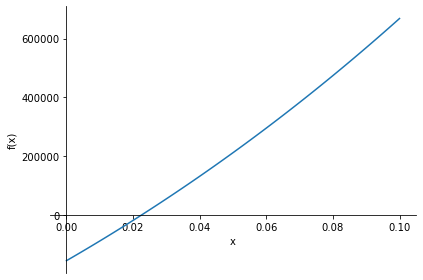

In [8]:
sp.plotting.plot(final_eq.subs({n:5, w:0, a: 15000, b: 100000, theta:5}), (x, 0, 0.1))

In [233]:
def sample_sparse_coefs(nx, p=0.8):
    return np.random.uniform(-1, 1, nx)*np.random.binomial(1, p, nx)
    
    
def sample_from(dist, mu, var, n):
    if dist == "gamma":
        return np.random.gamma(mu**2/var, np.abs(var/mu), n)
    
    if dist == "normal":
        return np.random.normal(mu, np.sqrt(var), n)
    
    if dist == "uniform":
        a = mu-np.sqrt(3 * var)
        return np.random.uniform(a, 2*mu - a, n)
    

def risk_fn(risk_latent):
    return expit(risk_latent)


def sample_default(risk):
    return np.random.binomial(1, risk)


def sample_loan_amt(base_latent_risk):
    return np.random.normal(15000 + 1000*base_latent_risk).clip(500)


def sample_installments(base_latent_risk):
    mu = np.clip(5+((base_latent_risk-base_latent_risk.mean())/base_latent_risk.std()), 0, np.inf)
    return np.random.poisson(mu*2)+1
    

def first_default(arr, axis):
    mask = arr!=1
    return np.where(mask.any(axis=axis), mask.argmax(axis=axis), arr.shape[1])


def defaulted_at_period(risk, periods):
    survival = np.power(1-risk, 1/periods)
    max_period = periods.max()
    survival_sequence = np.random.binomial(1, np.ones((len(survival), max_period))* survival.reshape(-1,1))
    survived_up_to = first_default(survival_sequence, axis=1)
    return np.clip(survived_up_to, 0, periods)
    

    
class LendingWorld(object):
    
    
    def __init__(self, nx=10, poly=2, bias=1, temp=0.01, seed=123):
        
        np.random.seed(seed)

        self.NX = nx
        self.POLY = poly
        self.POLY_GEN = PolynomialFeatures(self.POLY, include_bias=False)
        
        self.MUS = np.random.uniform(-2, 2, self.NX)
        self.VARS = np.random.exponential(1, self.NX)
        self.DISTS = np.random.choice(["normal"], self.NX)
        
        poly_mu = self.POLY_GEN.fit_transform(self.MUS.reshape(1, -1))
        
        self.NX_FINAL = poly_mu.shape[1]
        
        self.RISK_COEFS = sample_sparse_coefs(self.NX_FINAL)
        self.RISK_SENS_COEFS = sample_sparse_coefs(self.NX_FINAL)
        
        self.RISK_MU = poly_mu.dot(self.RISK_COEFS).mean()
        self.RISK_SENS_MU = poly_mu.dot(self.RISK_SENS_COEFS).mean()
        
        self.temp = temp
        self.bias = bias
        
        self.features = [f"col_{i+1}" for i in range(self.NX)]

    
    def baseline_risk_fn(self, x):
        return x.dot(self.RISK_COEFS) - self.RISK_MU
    
    
    def sample_risk_sens_fn(self, x):
        return x.dot(self.RISK_SENS_COEFS) - self.RISK_SENS_MU + 50
    
    
    def risk_latent_fn(self, x, price, risk_sens):
        return self.baseline_risk_fn(x)*0.2 + risk_sens*price
    
    
    def sample_features(self, n):
        X = np.hstack([sample_from(dist, mu, var, n).reshape(-1, 1)
                       for dist, mu, var in zip(self.DISTS, self.MUS, self.VARS)])
        
        X_poly = self.POLY_GEN.fit_transform(X)
        
        baseline_risk = self.baseline_risk_fn(X_poly)
        loan_amt = sample_loan_amt(baseline_risk)
        installments = sample_installments(baseline_risk)
        
        return (pd.DataFrame(X, columns=self.features)
                .assign(loan_amt = loan_amt,
                        installments=installments,))

    
    def outcome_fn(self, df, price):
        
        X = df[self.features]
        X_poly = self.POLY_GEN.fit_transform(X)
        
        risk_sens = self.sample_risk_sens_fn(X_poly)
        risk_latent = self.risk_latent_fn(X_poly, price, risk_sens)
        risk = risk_fn(risk_latent)

        survived_up_to = defaulted_at_period(risk, df["installments"].values)
        interest_revenues = df["loan_amt"]*((1+price)**survived_up_to - 1)
        
        default = (survived_up_to < df["installments"])*1
        loss = risk*df["loan_amt"]
        
        margin = interest_revenues - loss
        
        return df.assign(**dict(
            price=price,
            risk=risk,
            
            risk_baseline=self.baseline_risk_fn(X_poly), 
            risk_sens=risk_sens,
            risk_latent=risk_latent,
            
            interest_revenues=interest_revenues,
            survived_up_to=survived_up_to,
            default=default,
            loss=loss,
            
            margin = margin
        ))

        
        

world = LendingWorld(seed=10)

In [234]:
price_space = np.arange(.01, .1, .01)

loans = world.sample_features(n=5)
output = world.outcome_fn(loans, np.random.choice(price_space, len(loans)))
output.head()

,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,...,price,risk,risk_baseline,risk_sens,risk_latent,interest_revenues,survived_up_to,default,loss,margin
0,-1.084422,-2.367934,0.526254,2.191588,2.455746,-1.018886,-0.989530,1.165759,-3.330629,-1.301019,...,0.06,0.983096,2.596551,59.064255,4.063165,3361.058951,3,1,17298.258315,-13937.199364
1,1.666540,-0.637871,0.516337,0.413819,0.355857,-1.669902,-1.203196,1.637821,-0.812408,-0.647217,...,0.08,0.983671,1.102230,48.474123,4.098376,9449.771338,6,1,15838.944978,-6389.173640
2,-0.465659,-4.890899,0.474618,1.459461,0.796682,-0.514620,-1.393324,0.472148,0.076496,-1.634298,...,0.03,0.827323,0.162676,51.141213,1.566772,2415.101425,5,1,12544.845607,-10129.744182
3,-0.644756,1.014319,0.571579,0.964390,-1.388775,-0.673974,-2.507103,1.757196,-0.905655,-0.549230,...,0.04,0.092565,-22.678714,56.325690,-2.282715,184.284525,8,0,46.282313,138.002212
4,0.002893,0.120692,0.538920,0.277580,-0.941095,-1.862587,-2.152743,1.149425,2.342048,-4.329017,...,0.06,0.538707,-17.988401,62.547008,0.155140,209.259556,6,1,269.353742,-60.094186


In [235]:
np.random.seed(1)
output_exp = pd.concat([world.outcome_fn(loans.reset_index(), np.random.choice([p], len(loans)))
                        for p in price_space
                       ]).reset_index(drop=True)



In [236]:
output_exp.query("index==1").columns

Index(['index', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7',
       'col_8', 'col_9', 'col_10', 'loan_amt', 'installments', 'price', 'risk',
       'risk_baseline', 'risk_sens', 'risk_latent', 'interest_revenues',
       'survived_up_to', 'default', 'loss', 'margin'],
      dtype='object')

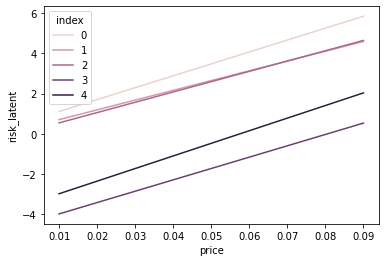

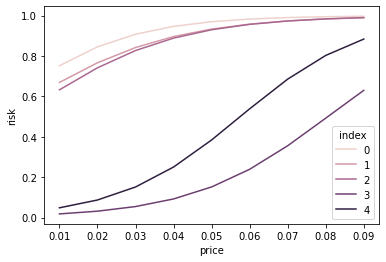

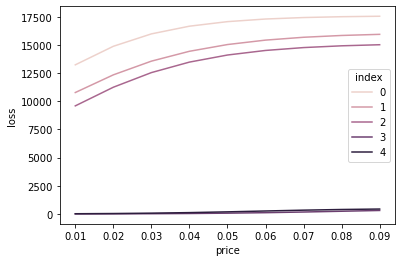

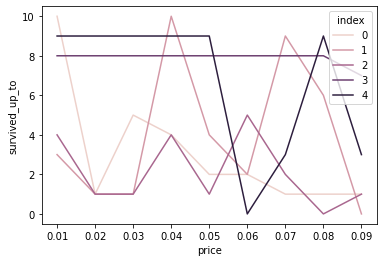

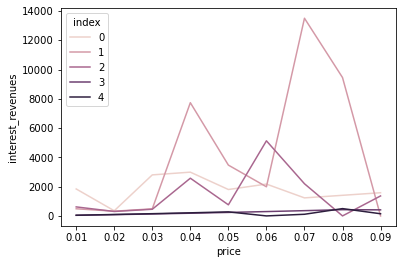

In [237]:
sns.lineplot(data=output_exp, x="price", y="risk_latent", hue="index")
plt.show()

sns.lineplot(data=output_exp, x="price", y="risk", hue="index")
plt.show()

sns.lineplot(data=output_exp, x="price", y="loss", hue="index")
plt.show()

sns.lineplot(data=output_exp, x="price", y="survived_up_to", hue="index")
plt.show()

sns.lineplot(data=output_exp, x="price", y="interest_revenues", hue="index")
plt.show()

In [238]:
price_space = np.arange(.01, .1, .01)

features = world.features

loans = world.sample_features(n=50000)
output = world.outcome_fn(loans, np.random.choice(price_space, len(loans)))



output.head()

,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,...,price,risk,risk_baseline,risk_sens,risk_latent,interest_revenues,survived_up_to,default,loss,margin
0,1.043153,-1.215860,0.499543,0.743099,1.506319,-2.290555,-1.756349,0.036257,-0.948337,-1.975928,...,0.09,0.975332,-6.470171,55.236659,3.677265,2516.497357,3,1,8319.250102,-5802.752745
1,0.839297,-2.677129,0.606073,0.204843,-0.518598,-1.244388,0.332802,1.100235,-3.158967,-2.840982,...,0.03,0.782883,-2.087077,56.665505,1.282550,2505.775229,6,1,10109.285402,-7603.510173
2,0.892141,-1.074467,0.541787,0.057075,-0.060754,-1.895005,-1.445646,0.383741,0.349189,-3.385184,...,0.06,0.699847,-12.569734,56.008568,0.846567,637.809858,4,1,1700.602692,-1062.792834
3,1.624801,-0.351342,0.540892,0.619737,0.653565,-0.693809,-3.735346,0.557465,-1.917141,-1.093447,...,0.06,0.761803,-9.302371,50.384427,1.162591,5765.334610,12,0,4339.128604,1426.206006
4,0.447245,-0.836745,0.568178,0.936584,1.865207,-1.385278,-1.744353,1.875536,-3.555830,-1.527544,...,0.07,0.981422,-3.017687,65.293369,3.966998,11589.271073,10,0,11760.268979,-170.997906


In [239]:
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score

rev_model = LGBMRegressor()
loss_model = LGBMRegressor()

X = output[features+["price"]]
rev_model.fit(X, output["interest_revenues"])
loss_model.fit(X, output["loss"])

print(rev_model.score(X, output["interest_revenues"]))
print(loss_model.score(X, output["loss"]))

r2_score(output["margin"], rev_model.predict(X) - loss_model.predict(X))

0.19641343344817397
0.9698507605746288


0.8690017719974308

In [240]:
np.random.seed(2)
new_sample = world.sample_features(n=50000)

price_alocation_sample = (new_sample.reset_index()
                          .assign(key=1)
                          .merge(pd.DataFrame(dict(price=price_space, key=1)))
                          .assign(loss_pred = lambda d: -loss_model.predict(d[features+["price"]]))
                          .assign(rev_pred = lambda d: rev_model.predict(d[features+["price"]]))
                          .assign(prediction = lambda d: rev_model.predict(d[features+["price"]]) - loss_model.predict(d[features+["price"]]))
                          .sort_values(["index", "prediction"], ascending=(True, False))
                          .groupby(["index"])
                          .first()
                         )

array([[<AxesSubplot:title={'center':'price'}>]], dtype=object)

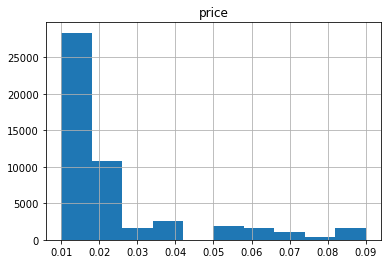

In [241]:
price_alocation_sample[["price"]].hist()

array([[<AxesSubplot:title={'center':'price'}>]], dtype=object)

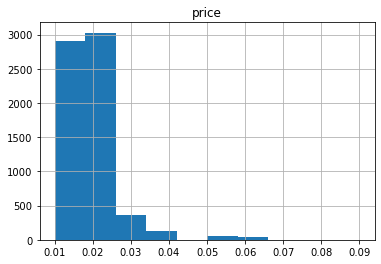

In [242]:
price_alocation_sample.query("prediction>0")[["price"]].hist()